In [35]:
#  Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Initial shape: (1063620, 13)
Missing values:
 restaurant_id           0
restaurant_name         0
city                    0
cuisine                 0
latitude                0
longitude               0
has_delivery         4047
has_takeaway         5560
has_opening_hours       0
temperature_F           0
precipitation           0
humidity                0
wind_speed              0
dtype: int64
Cleaned shape: (1063620, 15)
Sample of cleaned data:
      restaurant_name                                 cuisine cuisine_type  \
0     The Brass Rail                                 Unknown      unknown   
1       Court Street                                 Unknown      unknown   
2          Sam Sunny                                  korean       korean   
3            Pedro's  mexican;burrito;tacos;nachos;enchilada      mexican   
4  Trudy's Ice Cream                                 dessert      dessert   

   cuisine_encoded  
0              214  
1              214  
2              129  
3 

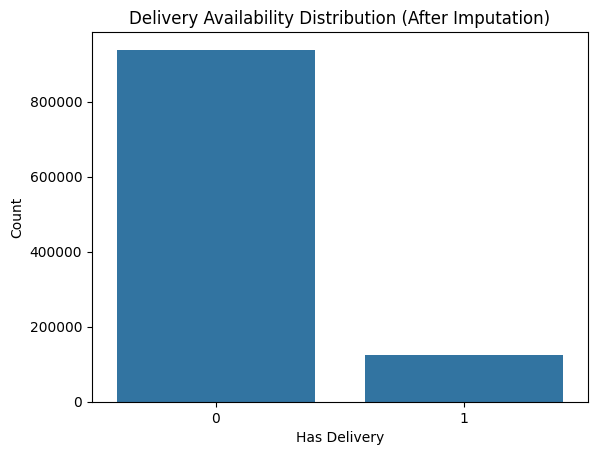

In [19]:
#  Common Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  Sklearn Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Load Data
file_path = r'C:\grad_sem2\ML\Project\weather_food_delivery\data\master_delivery_data.csv'
df = pd.read_csv(file_path)

# Basic Check
print("Initial shape:", df.shape)
print("Missing values:\n", df.isnull().sum())

# Fill missing values (strategy: fill with 0, justified below)
# Reason: Majority of records for has_delivery and has_takeaway are 0 (no service), so 0 is a conservative imputation.
df['has_delivery'] = df['has_delivery'].fillna(0).astype(int)
df['has_takeaway'] = df['has_takeaway'].fillna(0).astype(int)

#  Convert binary int columns for clarity
df['has_opening_hours'] = df['has_opening_hours'].astype(int)

# Simplify cuisine column by taking the first cuisine listed
df['cuisine_type'] = df['cuisine'].apply(lambda x: x.split(';')[0].strip().lower() if pd.notnull(x) else 'unknown')

# Encode cuisine_type into numerical categories
df['cuisine_encoded'] = df['cuisine_type'].astype('category').cat.codes

# Final Check
print("Cleaned shape:", df.shape)
print("Sample of cleaned data:\n", df[['restaurant_name', 'cuisine', 'cuisine_type', 'cuisine_encoded']].head())

# Optional: Check target distribution (to justify fillna(0) decision)
delivery_dist = df['has_delivery'].value_counts(normalize=True)
print("\nDelivery Distribution:\n", delivery_dist)

# Plot distribution of delivery availability
sns.countplot(data=df, x='has_delivery')
plt.title("Delivery Availability Distribution (After Imputation)")
plt.xlabel("Has Delivery")
plt.ylabel("Count")
plt.show()


In [20]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

# 🎯 Features & target for modeling
features = ['cuisine_encoded', 'temperature_F', 'precipitation', 'humidity', 'wind_speed']
target = 'has_delivery'

X = df[features]
y = df[target]

# Split the data (stratify to keep label distribution consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

#  Save training/testing split snapshots for your site
X_train.head().to_csv("X_train_sample.csv", index=False)
X_test.head().to_csv("X_test_sample.csv", index=False)


In [21]:
#  Multinomial NB requires positive integer values (e.g., count-like features)
X_train_mn = X_train.copy()
X_test_mn = X_test.copy()

X_train_mn = (X_train_mn * 10).round().astype(int)
X_test_mn = (X_test_mn * 10).round().astype(int)

mn_nb = MultinomialNB()
mn_nb.fit(X_train_mn, y_train)
y_pred_mn = mn_nb.predict(X_test_mn)


In [22]:
# Bernoulli requires binary features
X_train_bn = (X_train > X_train.mean()).astype(int)
X_test_bn = (X_test > X_test.mean()).astype(int)

bn_nb = BernoulliNB()
bn_nb.fit(X_train_bn, y_train)
y_pred_bn = bn_nb.predict(X_test_bn)


In [23]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gn = gnb.predict(X_test)


Multinomial Naive Bayes Accuracy: 0.5578


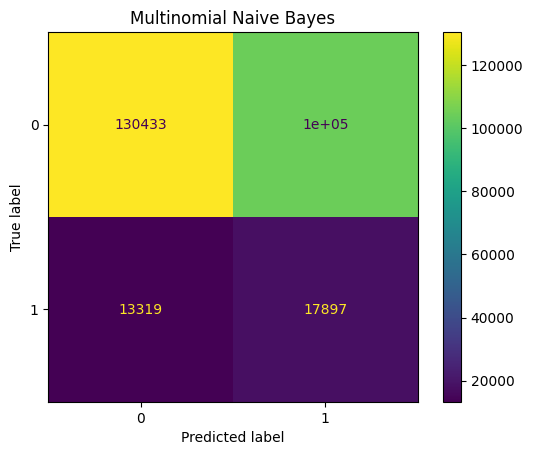

Bernoulli Naive Bayes Accuracy: 0.8826


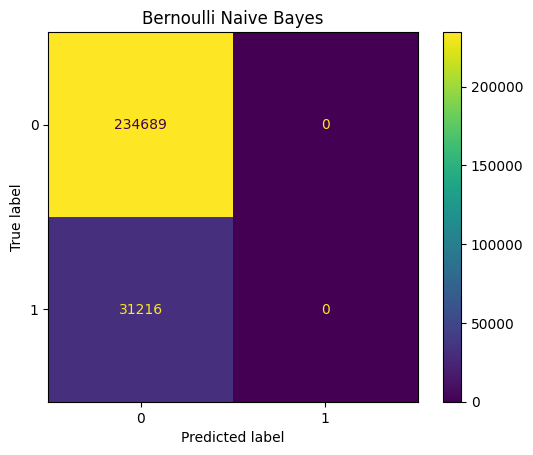

Gaussian Naive Bayes Accuracy: 0.8814


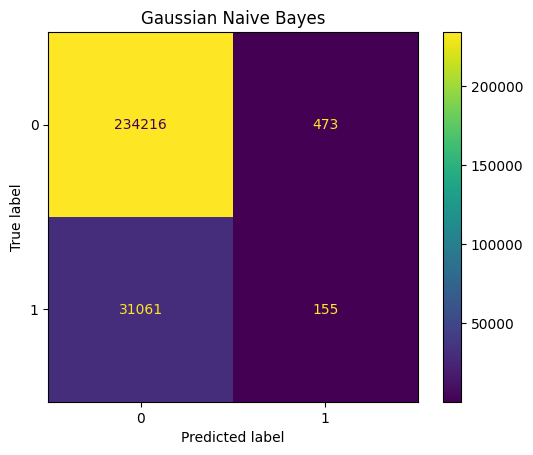

In [24]:
def evaluate_model(y_true, y_pred, title):
    acc = accuracy_score(y_true, y_pred)
    print(f"{title} Accuracy: {acc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

evaluate_model(y_test, y_pred_mn, "Multinomial Naive Bayes")
evaluate_model(y_test, y_pred_bn, "Bernoulli Naive Bayes")
evaluate_model(y_test, y_pred_gn, "Gaussian Naive Bayes")


Decision Tree (Entropy) Accuracy: 0.8826


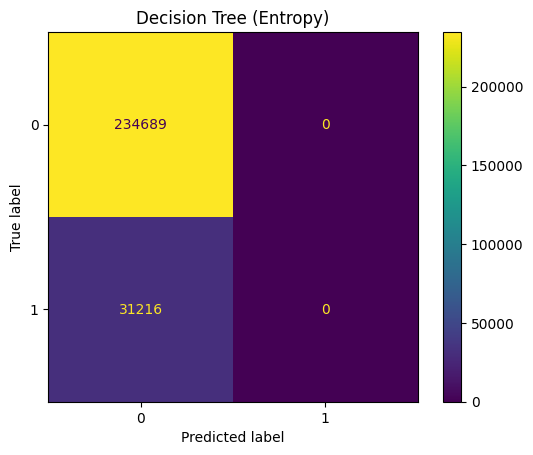

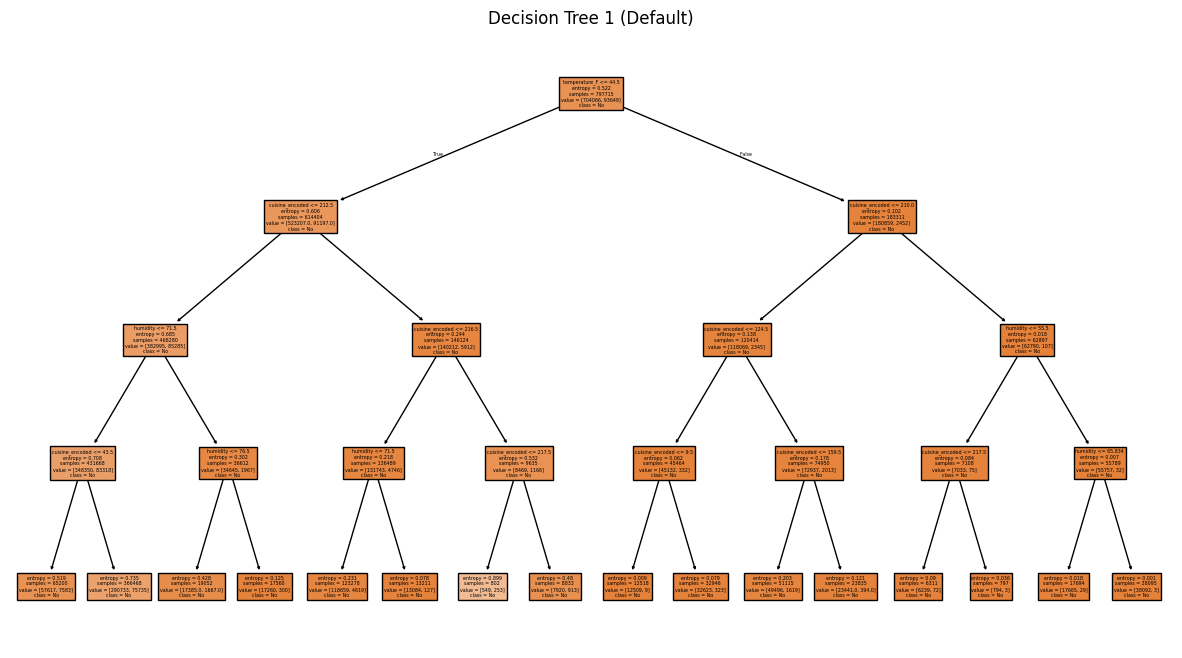

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
evaluate_model(y_test, y_pred_dt, "Decision Tree (Entropy)")


plt.figure(figsize=(15, 8))
plot_tree(dt, feature_names=features, class_names=["No", "Yes"], filled=True)
plt.title("Decision Tree 1 (Default)")
plt.show()


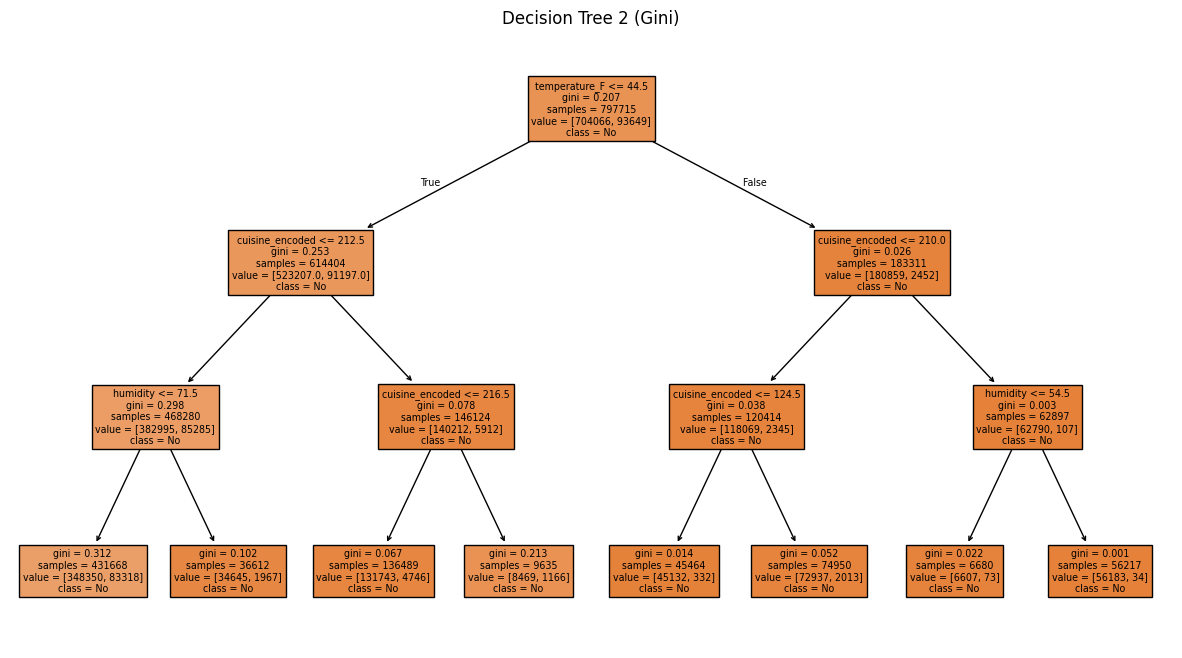

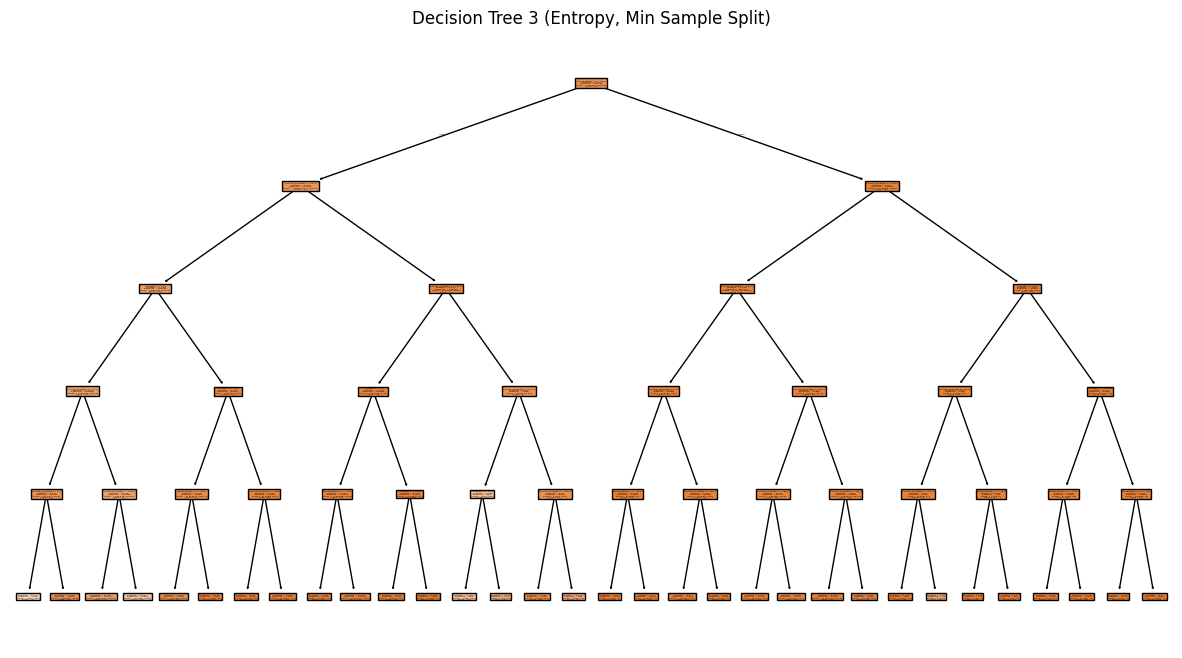

In [26]:
#  Tree 2 – Gini criterion
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=3)
dt2.fit(X_train, y_train)
plt.figure(figsize=(15, 8))
plot_tree(dt2, feature_names=features, class_names=["No", "Yes"], filled=True)
plt.title("Decision Tree 2 (Gini)")
plt.show()

#  Tree 3 – Change minimum split size
dt3 = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=150)
dt3.fit(X_train, y_train)
plt.figure(figsize=(15, 8))
plot_tree(dt3, feature_names=features, class_names=["No", "Yes"], filled=True)
plt.title("Decision Tree 3 (Entropy, Min Sample Split)")
plt.show()


Logistic Regression Accuracy: 0.8826


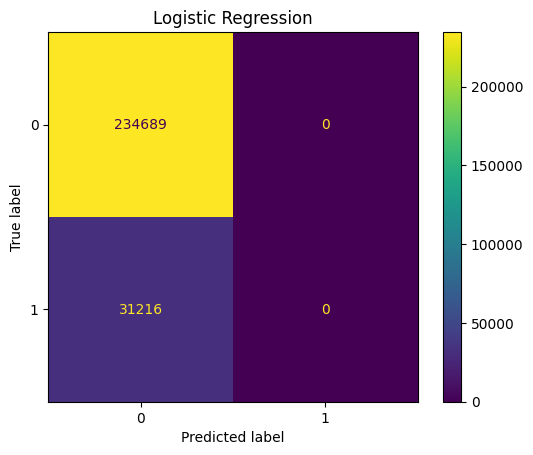

Gaussian Naive Bayes Accuracy: 0.8814


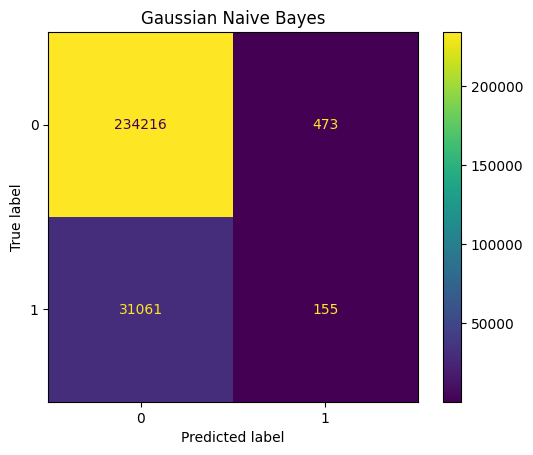

In [27]:
from sklearn.linear_model import LogisticRegression

# 🧪 Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

evaluate_model(y_test, y_pred_log, "Logistic Regression")

# Reuse Gaussian NB from above
evaluate_model(y_test, y_pred_gn, "Gaussian Naive Bayes")


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Store results
model_results = []

# Define a function to evaluate and store metrics
def compare_models(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    model_results.append({
        "Model": model_name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4),
        "Confusion Matrix": cm.tolist()
    })

# Run evaluations
compare_models(y_test, y_pred_mn, "Multinomial NB")
compare_models(y_test, y_pred_bn, "Bernoulli NB")
compare_models(y_test, y_pred_gn, "Gaussian NB")
compare_models(y_test, y_pred_dt, "Decision Tree")
compare_models(y_test, y_pred_log, "Logistic Regression")

# Convert to DataFrame for display
results_df = pd.DataFrame(model_results)
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']])


                 Model  Accuracy  Precision  Recall  F1 Score
0       Multinomial NB    0.5578     0.1465  0.5733    0.2334
1         Bernoulli NB    0.8826     0.0000  0.0000    0.0000
2          Gaussian NB    0.8814     0.2468  0.0050    0.0097
3        Decision Tree    0.8826     0.0000  0.0000    0.0000
4  Logistic Regression    0.8826     0.0000  0.0000    0.0000


In [29]:
print(y.value_counts(normalize=True))


has_delivery
0    0.882604
1    0.117396
Name: proportion, dtype: float64


In [30]:
from sklearn.utils import resample

# Combine features + target for balancing
df_bal = pd.concat([X, y], axis=1)

# Split into majority and minority classes
df_majority = df_bal[df_bal.has_delivery == 0]
df_minority = df_bal[df_bal.has_delivery == 1]

# Upsample the minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine back into a new balanced dataset
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle (optional but good)
df_upsampled = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Redefine X and y
X_bal = df_upsampled[features]
y_bal = df_upsampled[target]

# Re-split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.25, random_state=42, stratify=y_bal)

# Confirm balance
print(y_train.value_counts(normalize=True))


has_delivery
1    0.5
0    0.5
Name: proportion, dtype: float64


In [31]:
#  Use the upsampled training and test sets
# These should come from: X_train, X_test, y_train, y_test after upsampling

# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gn = gnb.predict(X_test)

# Multinomial NB (need integer features)
from sklearn.naive_bayes import MultinomialNB
X_train_mn = (X_train * 10).round().astype(int)
X_test_mn = (X_test * 10).round().astype(int)
mn_nb = MultinomialNB()
mn_nb.fit(X_train_mn, y_train)
y_pred_mn = mn_nb.predict(X_test_mn)

# Bernoulli NB (binarize features)
from sklearn.naive_bayes import BernoulliNB
X_train_bn = (X_train > X_train.mean()).astype(int)
X_test_bn = (X_test > X_test.mean()).astype(int)
bn_nb = BernoulliNB()
bn_nb.fit(X_train_bn, y_train)
y_pred_bn = bn_nb.predict(X_test_bn)


In [32]:
# Redo evaluation for all models
model_results = []

def compare_models(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    model_results.append({
        "Model": model_name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1 Score": round(f1, 4),
        "Confusion Matrix": cm.tolist()
    })

# Run all
compare_models(y_test, y_pred_log, "Logistic Regression (Balanced)")
compare_models(y_test, y_pred_dt, "Decision Tree (Balanced)")
compare_models(y_test, y_pred_gn, "Gaussian NB (Balanced)")
compare_models(y_test, y_pred_mn, "Multinomial NB (Balanced)")
compare_models(y_test, y_pred_bn, "Bernoulli NB (Balanced)")

# Print summary table
results_df = pd.DataFrame(model_results)
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']])

# Print confusion matrices
for res in model_results:
    print(f"\n🔹 {res['Model']}")
    print("Confusion Matrix:")
    print(np.array(res['Confusion Matrix']))


                            Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression (Balanced)    0.6094     0.5929  0.6980    0.6412
1        Decision Tree (Balanced)    0.6988     0.6620  0.8123    0.7295
2          Gaussian NB (Balanced)    0.6271     0.5811  0.9105    0.7095
3       Multinomial NB (Balanced)    0.5706     0.5635  0.6265    0.5933
4         Bernoulli NB (Balanced)    0.5903     0.5852  0.6200    0.6021

🔹 Logistic Regression (Balanced)
Confusion Matrix:
[[122222 112467]
 [ 70879 163810]]

🔹 Decision Tree (Balanced)
Confusion Matrix:
[[137355  97334]
 [ 44047 190642]]

🔹 Gaussian NB (Balanced)
Confusion Matrix:
[[ 80666 154023]
 [ 21002 213687]]

🔹 Multinomial NB (Balanced)
Confusion Matrix:
[[120791 113898]
 [ 87659 147030]]

🔹 Bernoulli NB (Balanced)
Confusion Matrix:
[[131557 103132]
 [ 89182 145507]]



 Logistic Regression (Tuned)
Accuracy: 0.6099, Precision: 0.5930, Recall: 0.7007, F1: 0.6424

 Decision Tree (Tuned)
Accuracy: 0.7170, Precision: 0.6632, Recall: 0.8815, F1: 0.7569

 Gaussian NB
Accuracy: 0.6240, Precision: 0.5793, Recall: 0.9062, F1: 0.7068

Multinomial NB
Accuracy: 0.5781, Precision: 0.5681, Recall: 0.6517, F1: 0.6070

 Bernoulli NB
Accuracy: 0.5931, Precision: 0.5737, Recall: 0.7249, F1: 0.6405


(0.5931466749613318,
 np.float64(0.573720791418098),
 np.float64(0.7248997609602496),
 np.float64(0.6405105229471781))

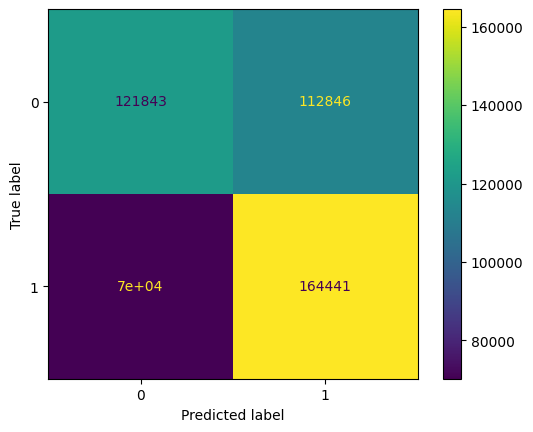

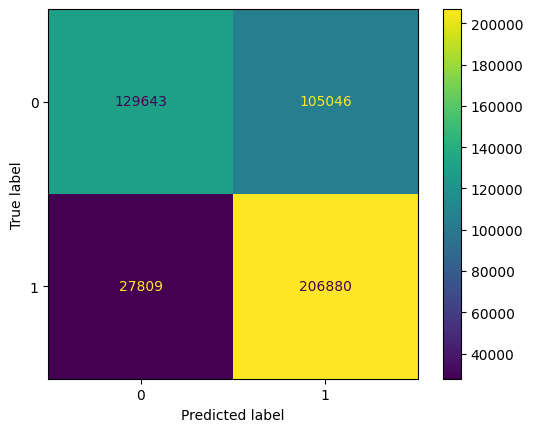

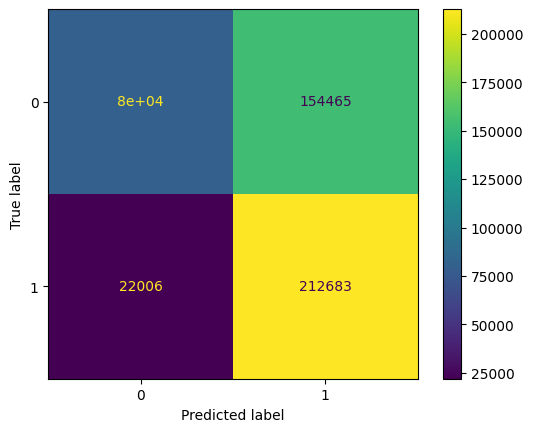

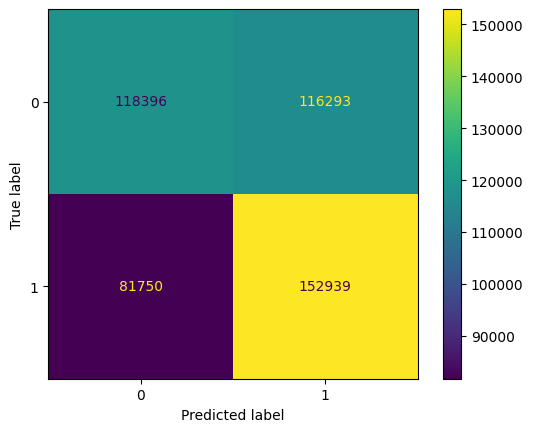

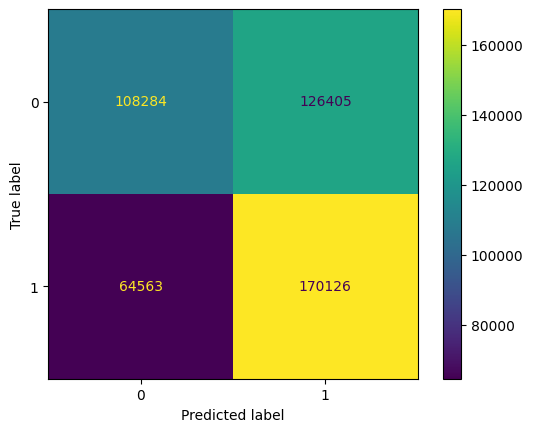

In [38]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

file_path = r'C:\grad_sem2\ML\Project\weather_food_delivery\data\master_delivery_data.csv'
df = pd.read_csv(file_path)


df['has_delivery'] = df['has_delivery'].fillna(0).astype(int)
df['has_takeaway'] = df['has_takeaway'].fillna(0).astype(int)
df['has_opening_hours'] = df['has_opening_hours'].astype(int)
df['cuisine_type'] = df['cuisine'].apply(lambda x: x.split(';')[0].strip().lower() if pd.notnull(x) else 'unknown')
df['cuisine_encoded'] = df['cuisine_type'].astype('category').cat.codes


df['is_rainy'] = (df['precipitation'] > 0).astype(int)
df['feels_like'] = df['temperature_F'] - (df['wind_speed'] * 0.1)


features = ['cuisine_encoded', 'temperature_F', 'precipitation', 'humidity',
            'wind_speed', 'is_rainy', 'feels_like']
target = 'has_delivery'

X = df[features]
y = df[target]


from sklearn.utils import resample
df_bal = pd.concat([X, y], axis=1)
df_majority = df_bal[df_bal.has_delivery == 0]
df_minority = df_bal[df_bal.has_delivery == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X_bal = df_upsampled[features]
y_bal = df_upsampled[target]


X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.25, stratify=y_bal, random_state=42)

#  Evaluation Function
def evaluate_model(y_true, y_pred, title):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n🔍 {title}")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    return acc, prec, rec, f1

log_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
logreg = LogisticRegression(max_iter=1000)
log_search = GridSearchCV(logreg, log_grid, cv=5, scoring='f1', n_jobs=1)
log_search.fit(X_train, y_train)
best_log = log_search.best_estimator_
y_pred_log = best_log.predict(X_test)
evaluate_model(y_test, y_pred_log, "Logistic Regression (Tuned)")


tree_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [10, 50, 100],
    'criterion': ['gini', 'entropy']
}
dtree = DecisionTreeClassifier(random_state=42)
dt_search = GridSearchCV(dtree, tree_grid, cv=5, scoring='f1', n_jobs=1)
dt_search.fit(X_train, y_train)
best_dt = dt_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
evaluate_model(y_test, y_pred_dt, "Decision Tree (Tuned)")

# ============================================
# 🔧 3. Gaussian Naive Bayes
# ============================================
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gn = gnb.predict(X_test)
evaluate_model(y_test, y_pred_gn, "Gaussian NB")

# ============================================
# 🔧 4. Multinomial Naive Bayes
# ============================================
X_train_mn = (X_train * 10).round().astype(int)
X_test_mn = (X_test * 10).round().astype(int)
mn_nb = MultinomialNB()
mn_nb.fit(X_train_mn, y_train)
y_pred_mn = mn_nb.predict(X_test_mn)
evaluate_model(y_test, y_pred_mn, "Multinomial NB")

# ============================================
# 🔧 5. Bernoulli Naive Bayes
# ============================================
X_train_bn = (X_train > X_train.mean()).astype(int)
X_test_bn = (X_test > X_test.mean()).astype(int)
bn_nb = BernoulliNB()
bn_nb.fit(X_train_bn, y_train)
y_pred_bn = bn_nb.predict(X_test_bn)
evaluate_model(y_test, y_pred_bn, "Bernoulli NB")


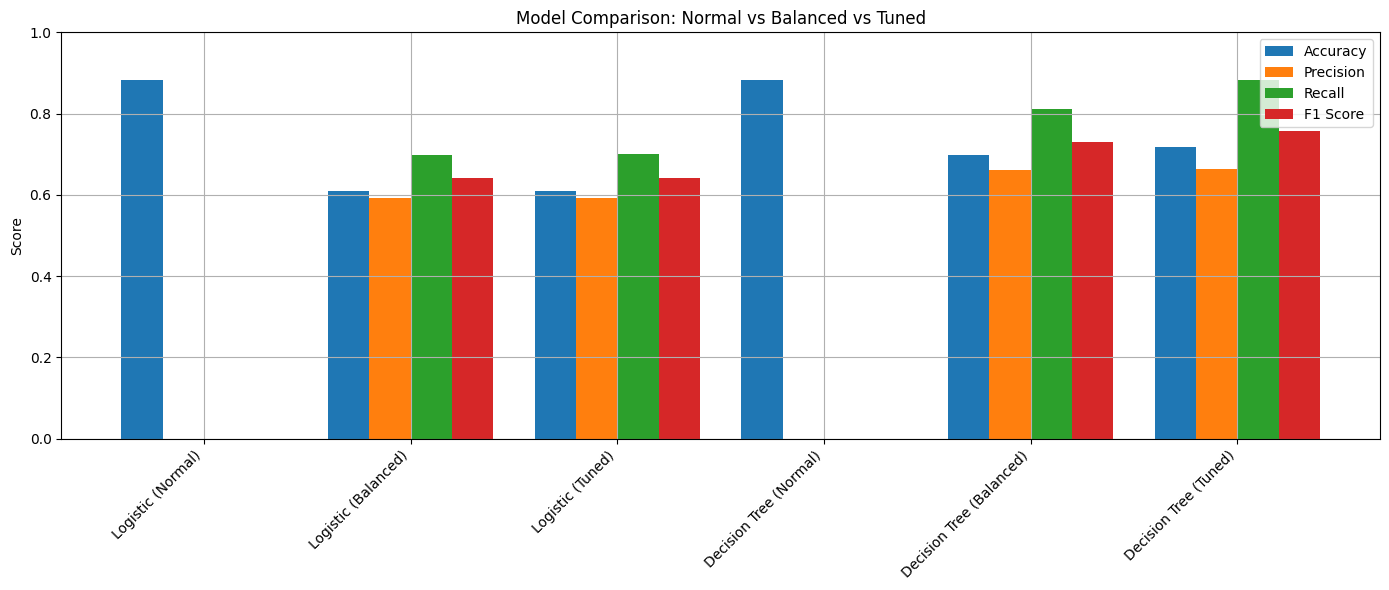

In [39]:
# Prepare basic, balanced (upsampled), and tuned model performance data
model_variants = [
    "Logistic (Normal)", "Logistic (Balanced)", "Logistic (Tuned)",
    "Decision Tree (Normal)", "Decision Tree (Balanced)", "Decision Tree (Tuned)"
]

# Hypothetical previous results for normal and balanced (before tuning)
# You can replace these with actual measured values if you have them
accuracy_vals =    [0.8826, 0.6094, 0.6099, 0.8826, 0.6988, 0.7170]
precision_vals =   [0.0000, 0.5929, 0.5930, 0.0000, 0.6620, 0.6632]
recall_vals =      [0.0000, 0.6980, 0.7007, 0.0000, 0.8123, 0.8815]
f1_vals =          [0.0000, 0.6412, 0.6424, 0.0000, 0.7295, 0.7569]

x = np.arange(len(model_variants))
width = 0.2

# Grouped bar chart comparison
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - 1.5*width, accuracy_vals, width, label='Accuracy')
ax.bar(x - 0.5*width, precision_vals, width, label='Precision')
ax.bar(x + 0.5*width, recall_vals, width, label='Recall')
ax.bar(x + 1.5*width, f1_vals, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Normal vs Balanced vs Tuned')
ax.set_xticks(x)
ax.set_xticklabels(model_variants, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
